In [2]:
import numpy as np
from scipy.special import hermite,legendre
from scipy.integrate import quad,nquad ## FUNCTIONS TO IMPLEMENT GAUSS-QUADRATURE
from scipy.integrate import quad_vec ## FUNCTIONS TO IMPLEMENT GAUSS-QUADRATURE
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
np.random.seed(20)

In [3]:
# Define the orthonormal probabilistic Hermite polynomial
def orthonormal_prob_hermite(n):
    return lambda x: hermite(n)(x/np.sqrt(2)) / np.sqrt(2**n * np.math.factorial(n))

# Define the orthonormal probabilistic Legendre polynomial
def orthonormal_legendre(n):
    return lambda x: legendre(n)(x) * np.sqrt(n+0.5)

def orthonormal_polynomial(i,j,k):
    return lambda x,y,z: orthonormal_prob_hermite(i)(x) * orthonormal_prob_hermite(j)(y) * orthonormal_legendre(k)(z)

# Define the integrand for scalar product

def scalar_product(i,j):
    result,_=quad_vec(lambda x:x*orthonormal_prob_hermite(i[0])(x) * orthonormal_prob_hermite(j[0])(x)*np.exp(-(x**2/2))/np.sqrt(2*np.pi), -10, 10)
    temp,_=quad_vec(lambda y:orthonormal_prob_hermite(i[1])(y) * orthonormal_prob_hermite(j[1])(y)* np.exp(-(y**2/2))/np.sqrt(2*np.pi), -10, 10)
    result = result * temp
    temp,_=quad_vec(lambda z:orthonormal_prob_hermite(i[2])(z) * orthonormal_prob_hermite(j[2])(z) *np.exp(-(z**2/2))/np.sqrt(2*np.pi) ,-10, 10)
    result = result * temp
    return result

# Integrate to verify orthonormality
integral1 = scalar_product((0,0,1),(1,0,1))
integral2 = scalar_product((2,1,1),(1,2,1))
print(f"The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_2(x) is approximately {integral1}")
print(f"The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_3(x) is approximately {integral2}")

The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_2(x) is approximately 1.0000000000000004
The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_3(x) is approximately -1.4374625781406634e-20


##### DEFINING THE KERNEL FUNCTIONS

In [4]:
## defining kernel derivative function

def W2(x, l):
    R = np.abs(x) / l
    a = 1 / l
    mask1 = R <= 1
    mask2 = np.logical_and(R > 1, R < 2)
    result = np.zeros_like(R)
    result[mask1] = (2/3 - R[mask1]**2 + 0.5 * R[mask1]**3) * a
    result[mask2] = ((2 - R[mask2])**3) / 6 * a
    return result

def kernel(x,h):
    rr=np.abs(x)
    q=rr/h
    drx=x/(h*rr)
    alpha_=2/(3*h)
    mask1 = q < 1
    mask2 = np.logical_and(q >= 1, q < 2)
    # print(mask1.shape)
    result = np.zeros_like(q)
    result[mask1]=alpha_*(-3*q[mask1]+2.25*q[mask1]**2)*drx[mask1]
    result[mask2]=-alpha_*0.75*(2-q[mask2])**2*drx[mask2]
    return result

## coefficent u
def u(x):
    return 0.1*x+0.06

## coefficient alpha
def alpha(z):
    return 0.01*z+0.25

## coefficient beta

def beta(y):
    return 0.1*y+2*np.pi



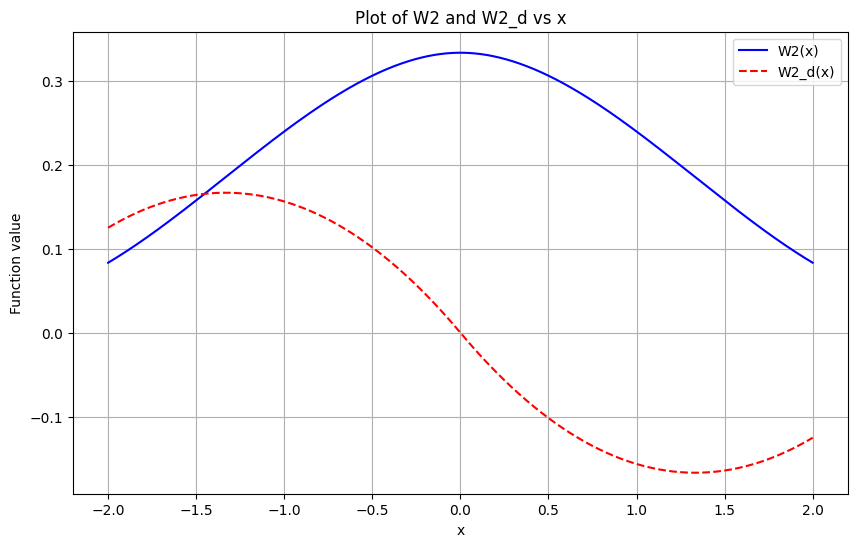

In [5]:
# Define the range of x values
x_values = np.linspace(-2, 2, 1200)

# Define a specific value for l
l = 2

# Calculate W2 and W2_d for each x value
W2_values = W2(x_values, l)
W2_d_values = kernel(x_values, l)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, W2_values, label='W2(x)', color='b')
plt.plot(x_values, W2_d_values, label='W2_d(x)', color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('Function value')
plt.title('Plot of W2 and W2_d vs x')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
integral1, _ = quad(lambda x: W2(x-0,0.1), -20, 20)
print(f"The kernel is normalised and hence the integral of it over the domain should be {integral1}")

The kernel is normalised and hence the integral of it over the domain should be 0.999999999970019


In [7]:
### DEFINING CONSTANTS
T = 0.5               # Total time of integration
dt = 0.001          # Time step
N = int(T/dt)       # No of time points
a = 1               # Length of space"
J = 512             # Space discretization points
P = 5               # No. of orthonarmal basis that is going to be used
d = 1.0/J
x = np.linspace(0,a,J)           # Discretization points

### define the triple indices for the basis
index=[]
for i in range(P):
    for j in range(P):
        for k in range(P):
            if(i+j+k<=4):
                index.append([i,j,k])
index=np.array(index)

In [8]:
index.shape

(35, 3)

In [9]:
def integrate(i,d=x):
    res,_=quad_vec(lambda x:orthonormal_prob_hermite(i[0])(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi), -10, 10)
    temp,_=quad_vec(lambda y:orthonormal_prob_hermite(i[1])(y) * np.sin(beta(y)*d)* np.exp(-(y**2/2))/np.sqrt(2*np.pi), -10, 10)
    res = res * temp
    temp,_=quad_vec(lambda z:orthonormal_prob_hermite(i[2])(z) * alpha(z) * np.exp(-(z**2/2))/np.sqrt(2*np.pi),-10, 10)
    res = res * temp
    return res

In [10]:
# # Applying Initial condition  
# def ic_integrand(x,y,z,i,d=x):
#     f = orthonormal_prob_hermite(i[0])(x) * np.sin(beta(y)*d) * alpha(z) * orthonormal_prob_hermite(i[1])(y) * orthonormal_prob_hermite(i[2])(z)
#     return f             
# ct = np.zeros((index.shape[0],J, N+1))
# for idx,i in enumerate(index):
#     print(idx)
#     sols=np.zeros_like(ct[idx,:,0])
#     for j in range(20000):
#         rv=np.random.normal(size=3)
#         sols+=ic_integrand(rv[0],rv[1],rv[2],i)
    
#     ct[idx,:,0]=sols/20000

In [11]:
ct = np.zeros((index.shape[0],J, N+1))
for idx,i in enumerate(index):
    ct[idx,:,0]=integrate(i)

### FOR SPH

In [12]:
## defining constants
n_particles=J    ###  number of particles
dv = 1/n_particles   ### particle volume
rho0 = 1    ##### defining some random value of intial particle density
m_i = rho0*dv    ###### mass associated with each particle
c = 40/J    ###  radius/cutoff distance 
h = 1.2/J    ### smoothing length

#### creating neigbor list for particle
n_list = [ [] for i in range(n_particles) ]
x_dis = [ [] for i in range(n_particles) ]
for i in range(n_particles):
    for j in range(n_particles):
        if(i>j):
            k=-1
        else:
            k=1
        if(i!=j):
            if(np.linalg.norm(x[i]-x[j])<c):
                n_list[i].append(j)
                x_dis[i].append(x[i]-x[j])
            elif(a+dv-np.linalg.norm(x[i]-x[j])<c):
                n_list[i].append(j)
                x_dis[i].append(k*(a+dv-np.linalg.norm(x[i]-x[j])))
n_list=np.array(n_list)
x_dis=np.array(x_dis)

In [13]:
len(n_list[0])

78

In [14]:
### function to approximate the space derivative using SPH


def SPH(c,h,n_list=n_list):
    cd=np.zeros_like(c)
    for i,neighbors in enumerate(n_list):
        c_i = c[:, i][:, np.newaxis]  # Broadcasting to create the necessary shape
        c_i = np.repeat(c_i, len(neighbors), axis=1)
        c_j=c[:,neighbors]
        cd[:,i] = np.dot((c_i-c_j), -(kernel(x_dis[i], h))) * dv
    return cd

In [15]:
def integrate2(i,j):
    result,_=quad_vec(lambda x:u(x)*orthonormal_prob_hermite(i[0])(x) * orthonormal_prob_hermite(j[0])(x)*np.exp(-(x**2/2))/np.sqrt(2*np.pi), -10, 10)
    temp,_=quad_vec(lambda y:orthonormal_prob_hermite(i[1])(y) * orthonormal_prob_hermite(j[1])(y)* np.exp(-(y**2/2))/np.sqrt(2*np.pi), -10, 10)
    result = result * temp
    temp,_=quad_vec(lambda z:orthonormal_prob_hermite(i[2])(z) * orthonormal_prob_hermite(j[2])(z) *np.exp(-(z**2/2))/np.sqrt(2*np.pi) ,-10, 10)
    result = result * temp
    return result
# Precompute the scalar product values values
tot_P=index.shape[0]
values=np.zeros(shape=(tot_P,tot_P))
for i in range(tot_P):
    print(i)
    for j in range(tot_P):
        values[i,j]=integrate2(index[i],index[j])
        if(abs(values[i,j])<1e-15):
            values[i,j]=0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [16]:
tot_P

35

In [17]:
### Solving using predictor-corrector scheme
for n in range(1, N+1):
    c = ct[:, :, n-1]
    cd = SPH(c, h)
    rhs = np.zeros_like(cd)
    for i in range(tot_P):
        for j in range(tot_P):
            rhs[i, :] += cd[j, :] * values[i, j]

    # Predictor step
    ct_pred = ct[:, :, n-1] + rhs * dt

    # Corrector step
    cd_pred = SPH(ct_pred, h)
    rhs_pred = np.zeros_like(cd_pred)
    for i in range(tot_P):
        for j in range(tot_P):
            rhs_pred[i, :] += cd_pred[j, :] * values[i, j]

    ct[:, :, n] = ct[:, :, n-1] + 0.5 * (rhs + rhs_pred) * dt

    print(f"Completed the {n}^th timestep")

Completed the 1^th timestep
Completed the 2^th timestep
Completed the 3^th timestep
Completed the 4^th timestep
Completed the 5^th timestep
Completed the 6^th timestep
Completed the 7^th timestep
Completed the 8^th timestep
Completed the 9^th timestep
Completed the 10^th timestep
Completed the 11^th timestep
Completed the 12^th timestep
Completed the 13^th timestep
Completed the 14^th timestep
Completed the 15^th timestep
Completed the 16^th timestep
Completed the 17^th timestep
Completed the 18^th timestep
Completed the 19^th timestep
Completed the 20^th timestep
Completed the 21^th timestep
Completed the 22^th timestep
Completed the 23^th timestep
Completed the 24^th timestep
Completed the 25^th timestep
Completed the 26^th timestep
Completed the 27^th timestep
Completed the 28^th timestep
Completed the 29^th timestep
Completed the 30^th timestep
Completed the 31^th timestep
Completed the 32^th timestep
Completed the 33^th timestep
Completed the 34^th timestep
Completed the 35^th tim

In [18]:
#### LET'S CALCULATE mean 
def calculate_mean(ct,tot_P):
    f=0
    for idx in range(tot_P):
        i=index[idx]
        res,_=quad_vec(lambda x:orthonormal_prob_hermite(i[0])(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi), -10, 10) 
        temp,_=quad_vec(lambda y:orthonormal_prob_hermite(i[1])(y) *  np.exp(-(y**2/2))/np.sqrt(2*np.pi), -10, 10)
        res = res * temp
        temp,_=quad_vec(lambda z:orthonormal_prob_hermite(i[2])(z) * np.exp(-(z**2/2))/np.sqrt(2*np.pi), -10, 10)
        res = res * temp
        f+=res * ct[idx,:,:]
    return  f

# u_mean=ct[0,:,:]/2
u_mean=ct[0,:,:]

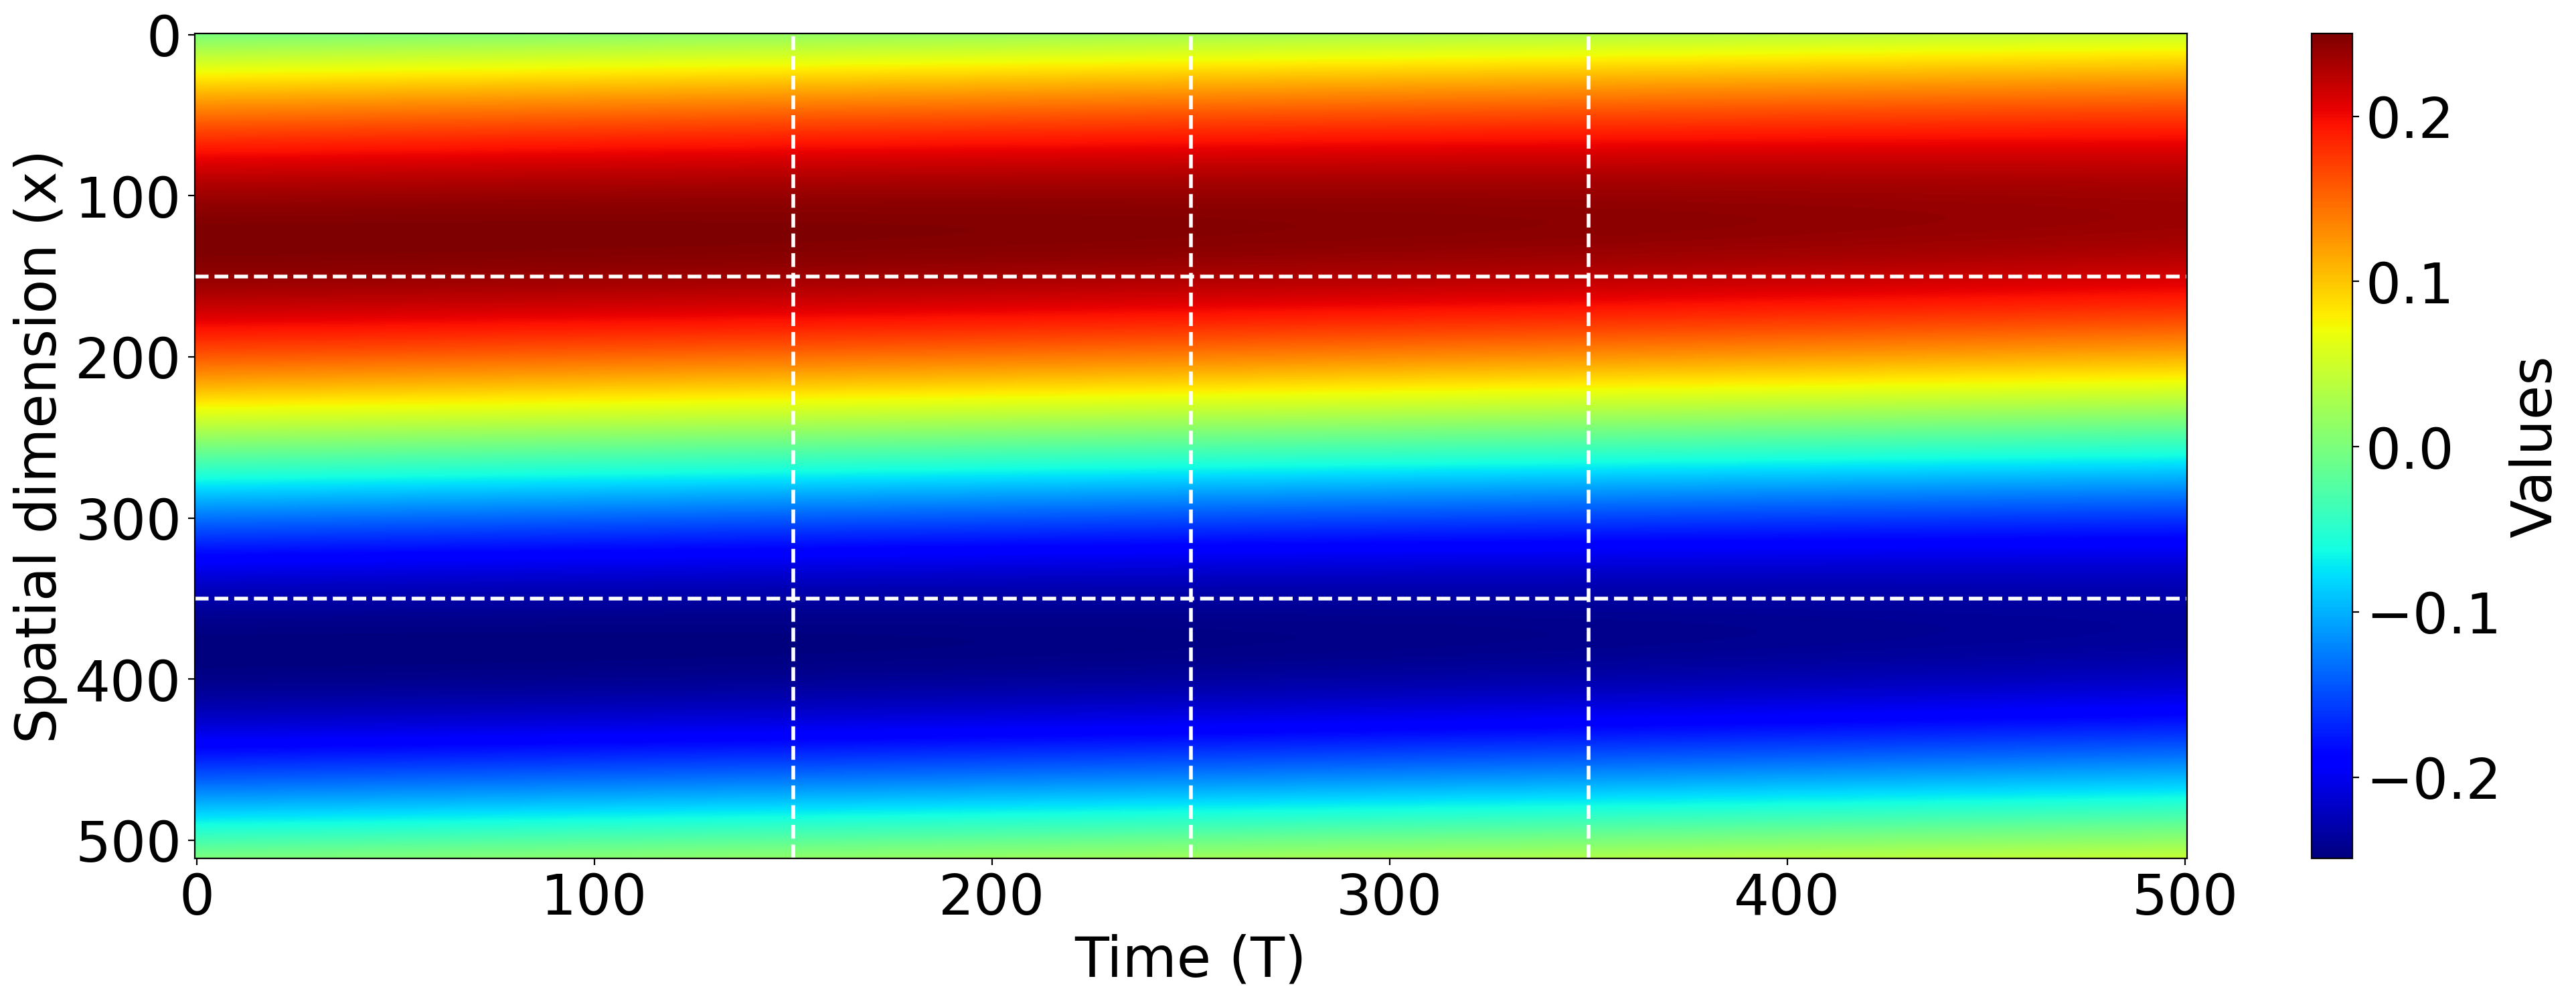

In [19]:
# set font sizes and math font
plt.rcParams['font.size'] = 30
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# create figure
fig1 = plt.figure(figsize=(24, 8), dpi=200)

# plot heatmap
heatmap = plt.imshow(u_mean, aspect='auto', cmap='jet')

# add vertical lines at t = 150, 250, 350
for t in [150, 250, 350]:
    plt.axvline(x=t, color='white', linestyle='--', linewidth=2)

# add horizontal lines at x = 150, 350
for y in [150, 350]:
    plt.axhline(y=y, color='white', linestyle='--', linewidth=2)

# labels and colorbar
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')

plt.show()

In [20]:
#### LET'S CALCULATE variance
def calculate_sq(ct,tot_P,u_mean):
    f=0
    for idx in range(1,tot_P):
        # print((ct[idx,:,:]**2).shape)
        f+= (ct[idx,:,:]**2)
    # print(f.shape)
    return  f
u_std=np.sqrt(calculate_sq(ct,tot_P,u_mean))

# print(type(u_std))
if(type(u_std)==np.float64):
    print("yes")
    u_std = np.zeros_like(u_mean)


In [21]:

import pickle
with open('results_exp4_MEAN_mcs.pkl', 'rb') as file:
    mean_mcs=pickle.load(file)
with open('results_exp4_STD_mcs.pkl', 'rb') as file:
    std_mcs=pickle.load(file)

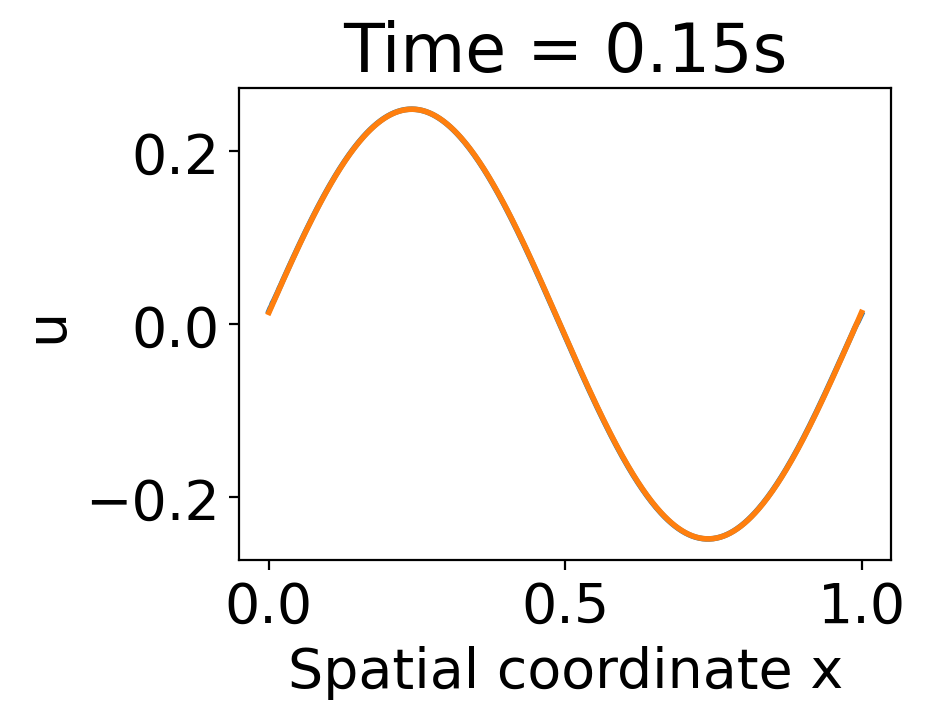

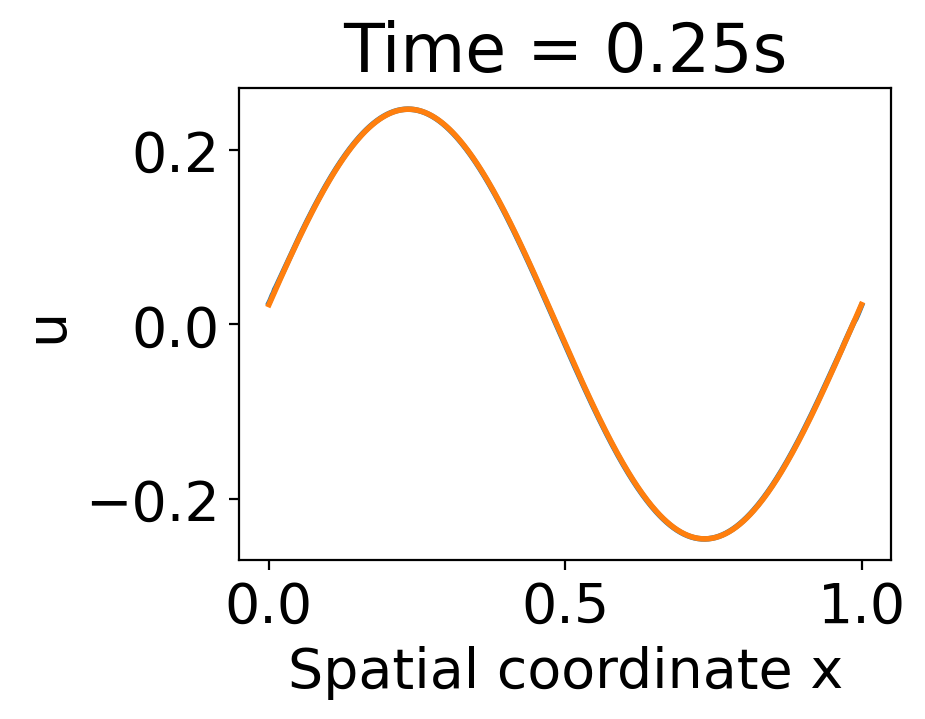

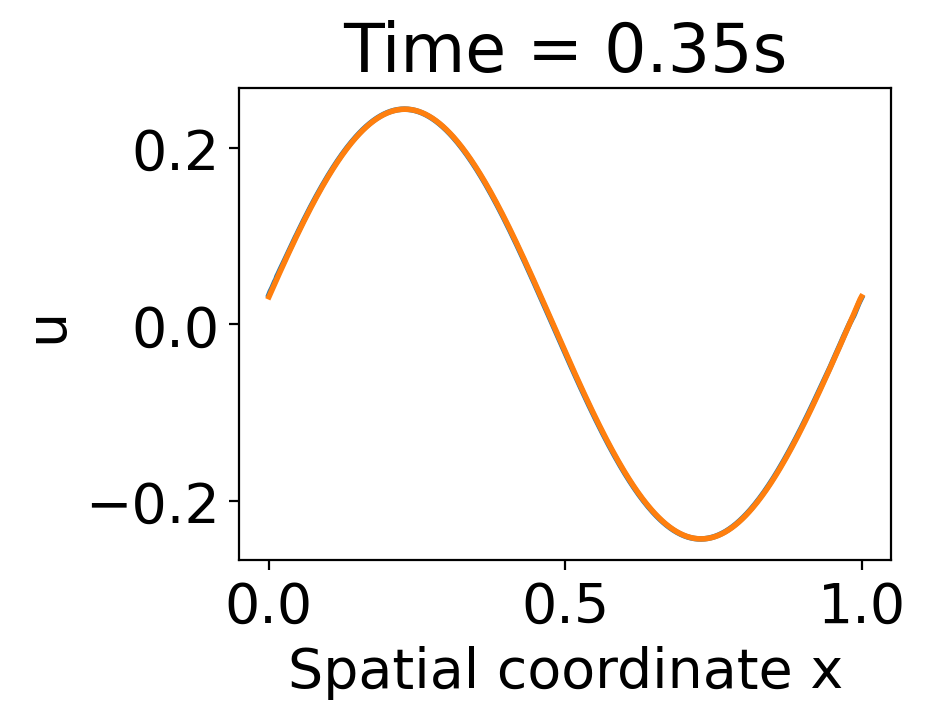

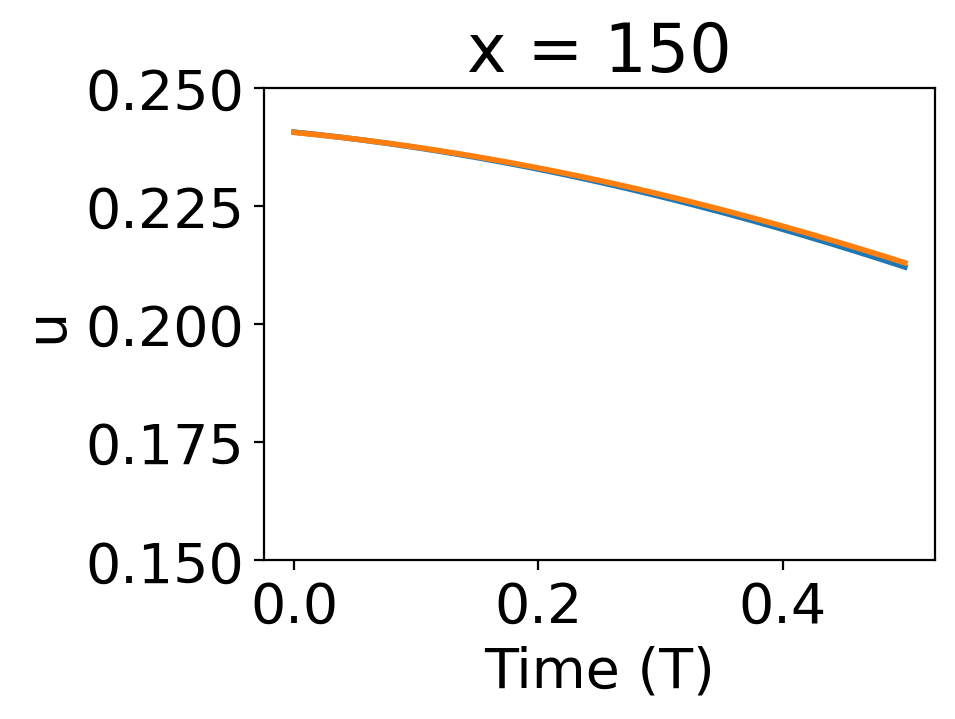

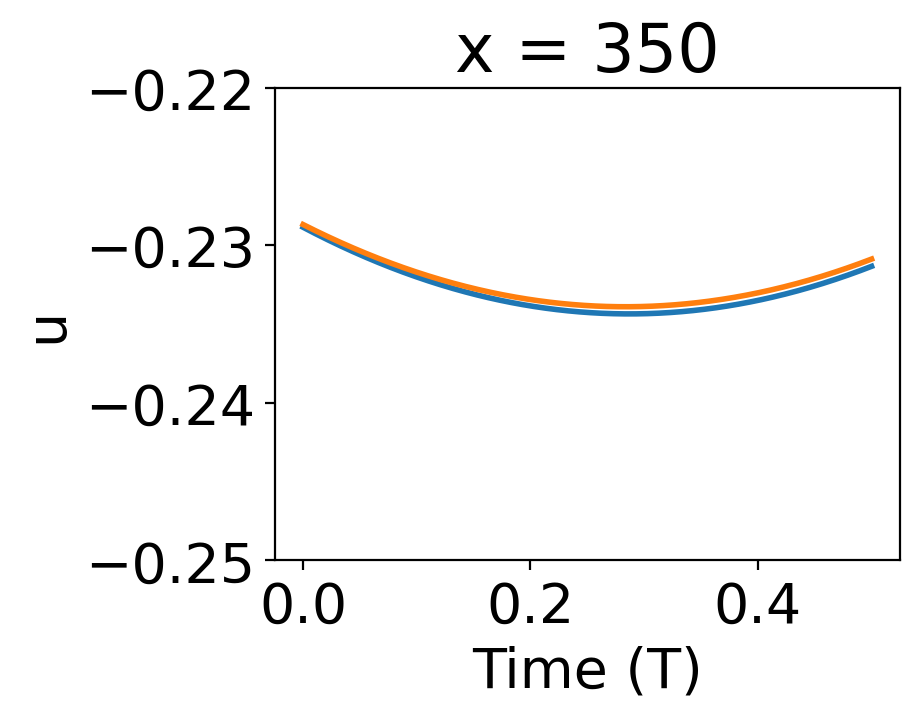

In [22]:

plt.rcParams['font.size'] = 20
# ------------------------------------------------------
# 1) Prepare your data & coordinates
# ------------------------------------------------------
# u_mean: 2D array of shape (nx, nt)
# x:    1D array (length nx) giving the spatial grid coordinates
# t:    1D array (length nt) giving the time grid coordinates

# Example placeholders (replace with your real arrays):
x = np.linspace(0, 1, u_mean.shape[0])
t = np.linspace(0, 0.5, u_mean.shape[1])

# ------------------------------------------------------
# 2) Choose five slices in time and five in space
# ------------------------------------------------------
fixed_times = [150, 250, 350]   # time-coordinates you want to hold fixed
fixed_xs    = [150, 350]   # spatial-coordinates you want to hold fixed

# find the nearest indices in your grid
time_inds = [np.abs(ti) for ti in fixed_times]
x_inds    = [np.abs(xi) for xi in fixed_xs]

# ------------------------------------------------------
# 3) Plot u(x) at each fixed time
# ------------------------------------------------------
for ti, tval in zip(time_inds, fixed_times):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(x, u_mean[:, ti], linewidth=2)
    plt.plot(x, mean_mcs[:, ti], linewidth=2)
    plt.title(f'Time = {tval/1000}s')
    plt.xlabel('Spatial coordinate x')
    plt.ylabel('u')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------
# 4) Plot u(t) at each fixed spatial location
# ------------------------------------------------------
i=0
for xi, xval in zip(x_inds, fixed_xs):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(t, u_mean[xi, :], linewidth=2)
    plt.plot(t, mean_mcs[xi, :], linewidth=2)
    plt.title(f'x = {xval}')
    plt.xlabel('Time (T)')
    plt.ylabel('u')
    if(i==0):
        plt.ylim(0.15,0.25)
    else:
        plt.ylim(-0.250,-0.220)
        
    i+=1
    plt.tight_layout()
    plt.show()

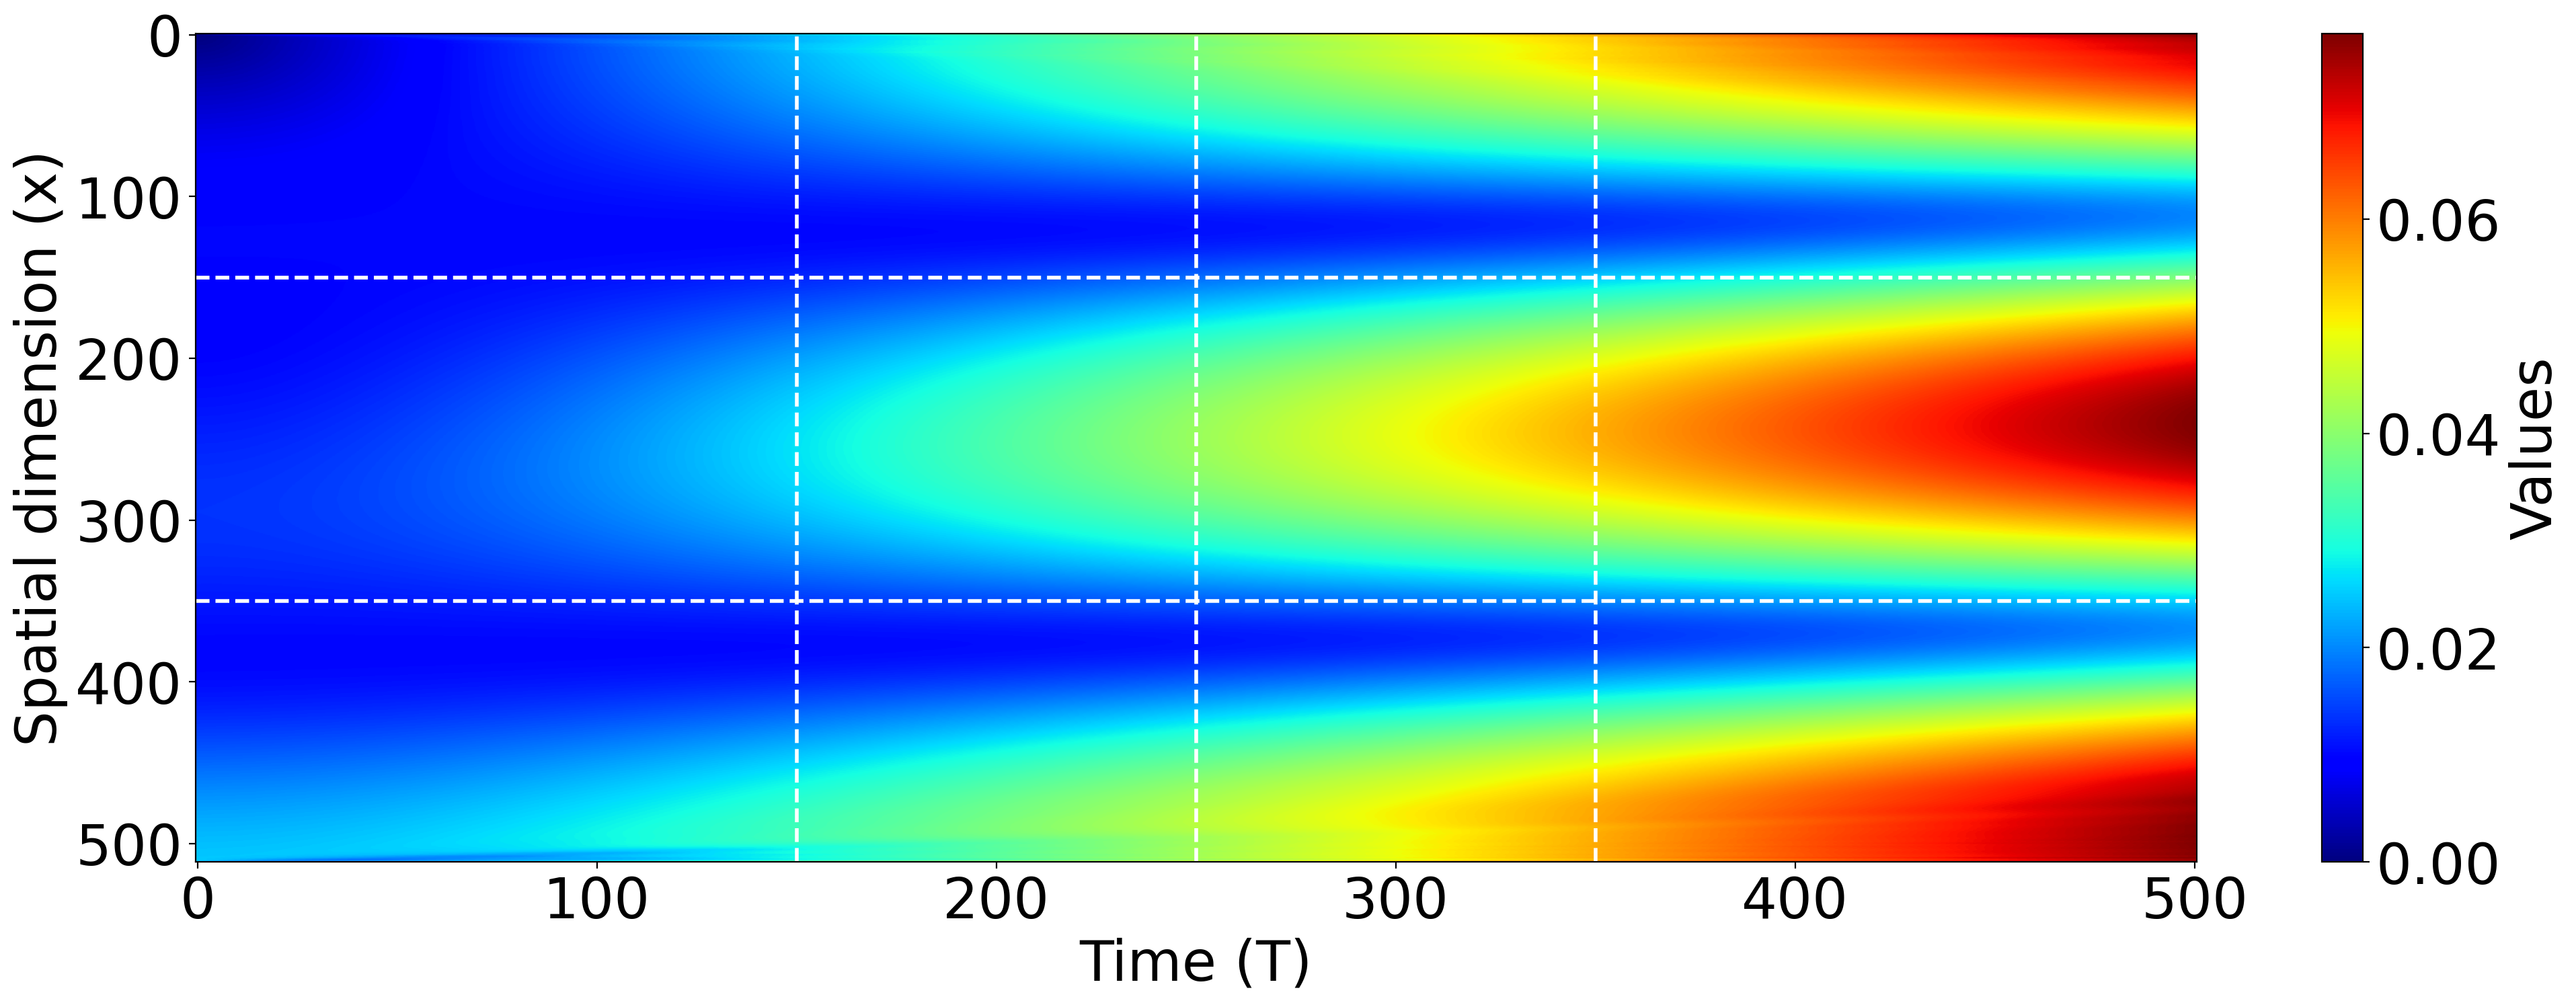

In [23]:
# set font sizes and math font
plt.rcParams['font.size'] = 30
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# create figure
fig1 = plt.figure(figsize=(24, 8), dpi=200)

# plot heatmap
heatmap = plt.imshow(u_std, aspect='auto', cmap='jet')

# add vertical lines at t = 150, 250, 350
for t in [150, 250, 350]:
    plt.axvline(x=t, color='white', linestyle='--', linewidth=2)

# add horizontal lines at x = 150, 350
for y in [150, 350]:
    plt.axhline(y=y, color='white', linestyle='--', linewidth=2)

# labels and colorbar
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')

plt.show()

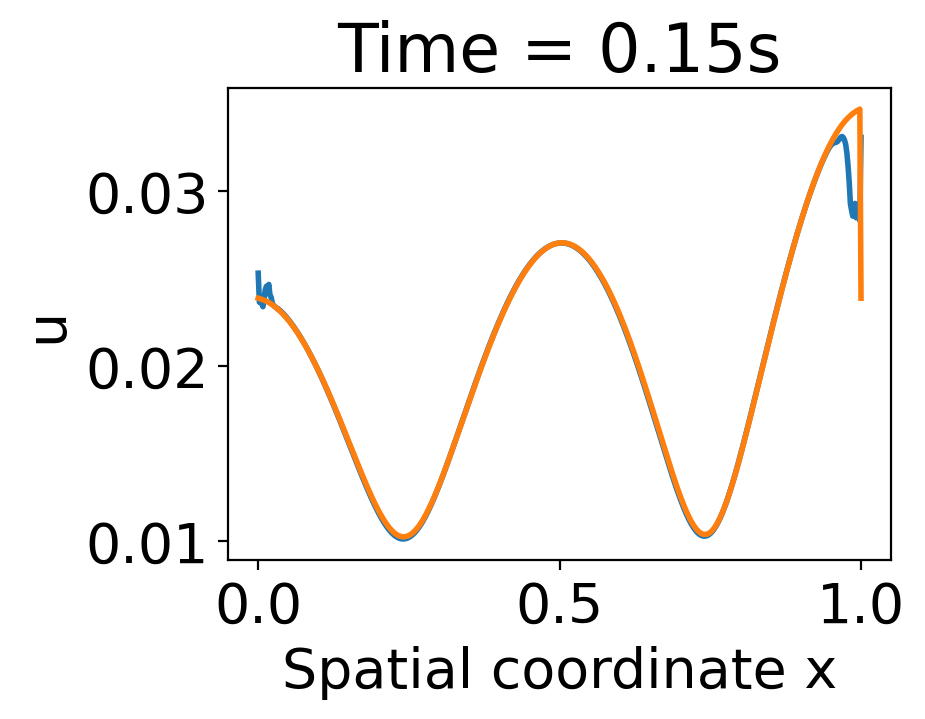

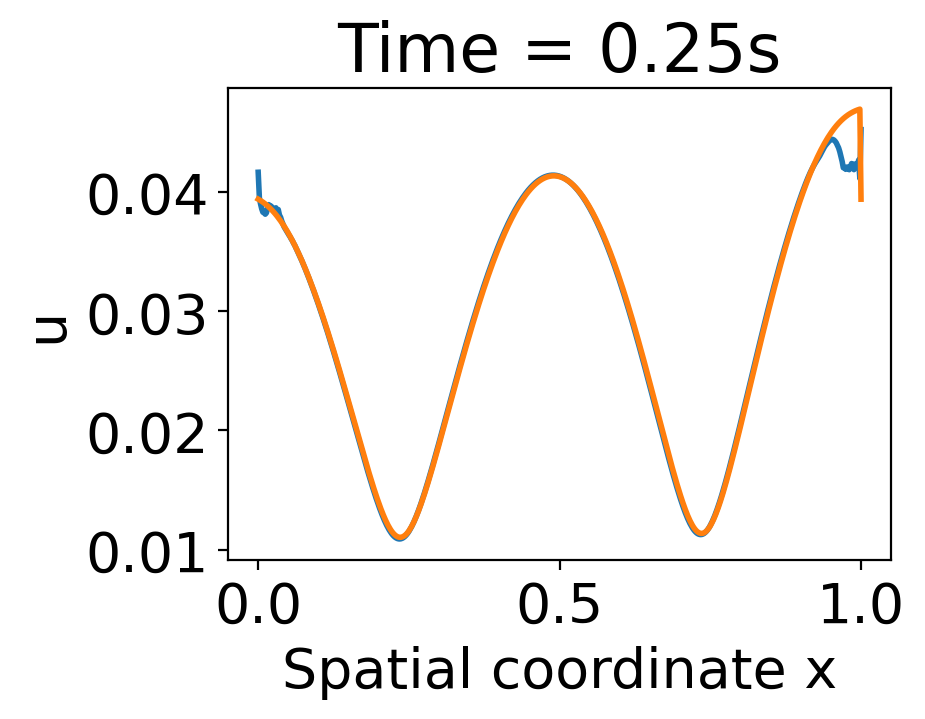

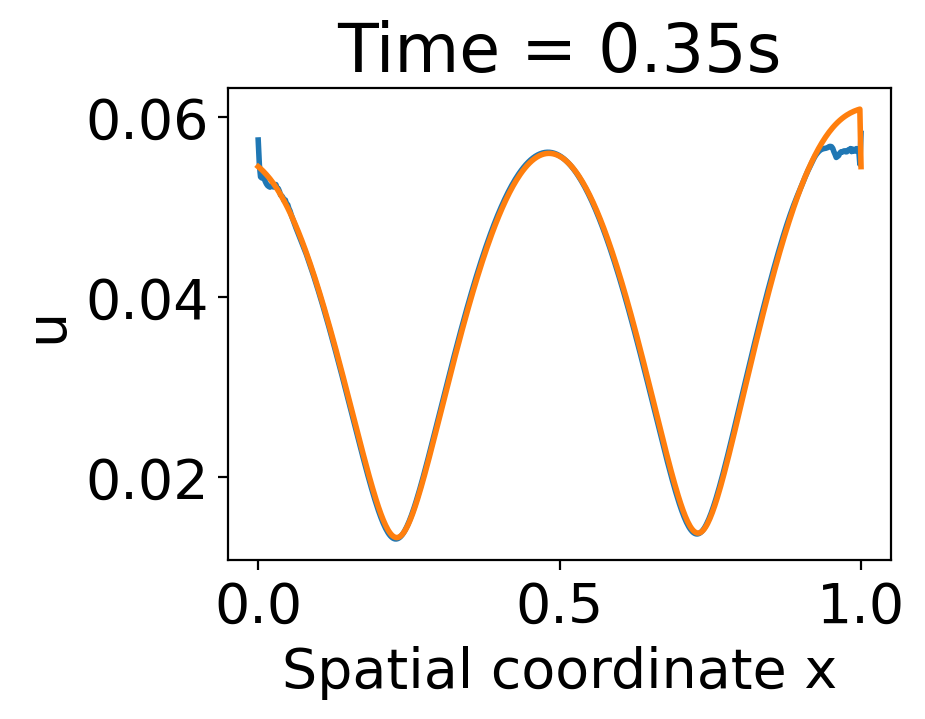

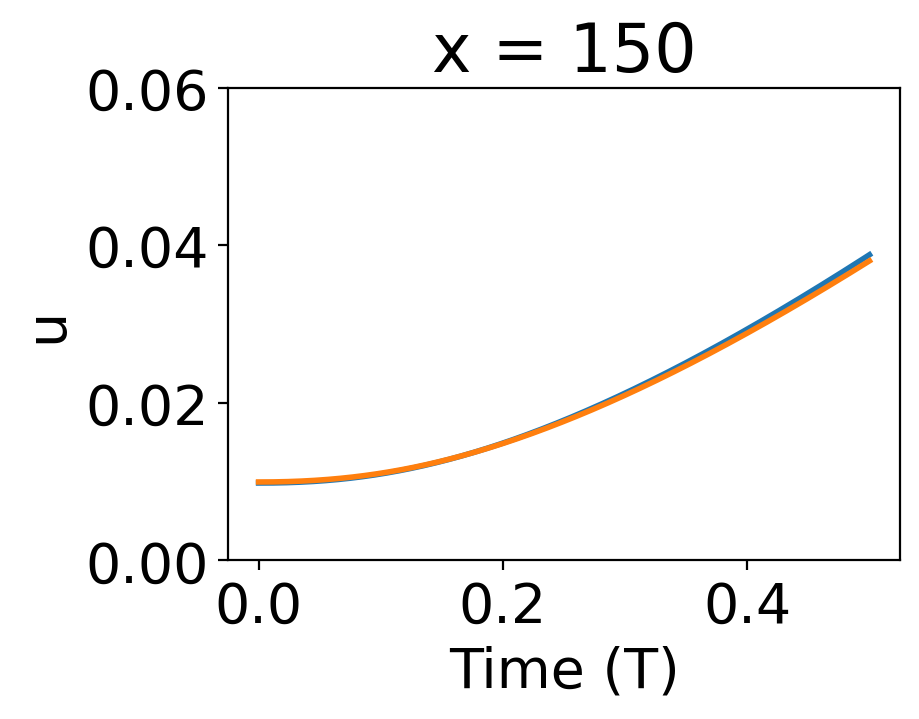

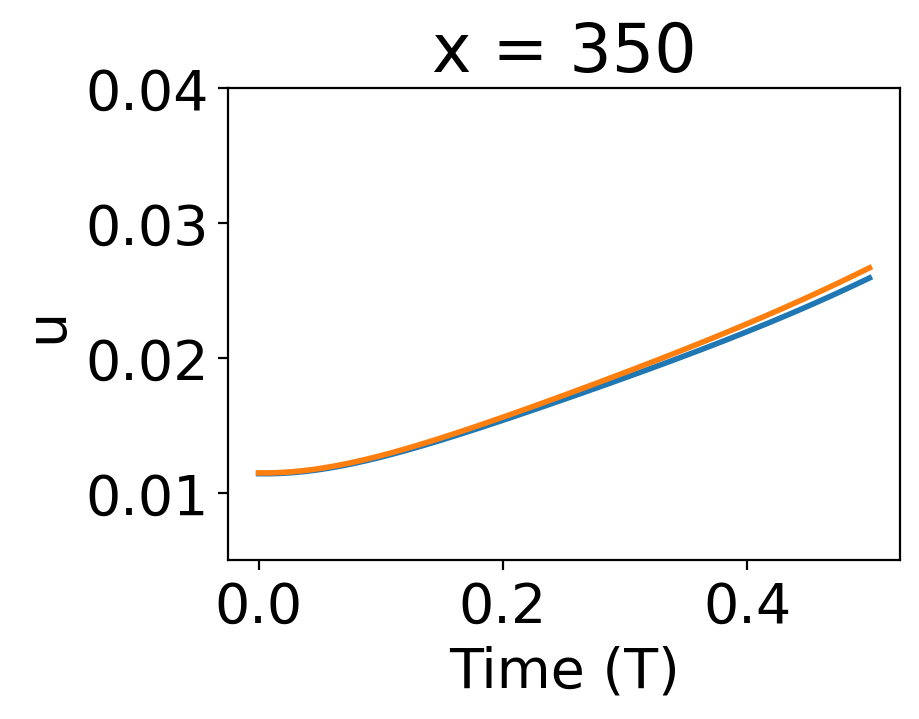

In [29]:
plt.rcParams['font.size'] = 20
# ------------------------------------------------------
# 1) Prepare your data & coordinates
# ------------------------------------------------------
# u_mean: 2D array of shape (nx, nt)
# x:    1D array (length nx) giving the spatial grid coordinates
# t:    1D array (length nt) giving the time grid coordinates

# Example placeholders (replace with your real arrays):
x = np.linspace(0, 1, u_mean.shape[0])
t = np.linspace(0, 0.5, u_mean.shape[1])

# ------------------------------------------------------
# 2) Choose five slices in time and five in space
# ------------------------------------------------------
fixed_times = [150, 250, 350]   # time-coordinates you want to hold fixed
fixed_xs    = [150, 350]   # spatial-coordinates you want to hold fixed

# find the nearest indices in your grid
time_inds = [np.abs(ti) for ti in fixed_times]
x_inds    = [np.abs(xi) for xi in fixed_xs]

# ------------------------------------------------------
# 3) Plot u(x) at each fixed time
# ------------------------------------------------------
for ti, tval in zip(time_inds, fixed_times):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(x, u_std[:, ti], linewidth=2)
    plt.plot(x, std_mcs[:, ti], linewidth=2)
    plt.title(f'Time = {tval/1000}s')
    plt.xlabel('Spatial coordinate x')
    plt.ylabel('u')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------
# 4) Plot u(t) at each fixed spatial location
# ------------------------------------------------------
i=0
for xi, xval in zip(x_inds, fixed_xs):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(t, u_std[xi, :], linewidth=2)
    plt.plot(t, std_mcs[xi, :], linewidth=2)
    plt.title(f'x = {xval}')
    plt.xlabel('Time (T)')
    plt.ylabel('u')
    if(i==0):
        plt.ylim(0,0.06)
    else:
        plt.ylim(0.005,0.04)
        
    i+=1
    plt.tight_layout()
    plt.show()

In [25]:
import pickle
with open('results_exp4_01.pkl', 'wb') as file:
    pickle.dump(ct, file)